# Analyses of reconstruction error


### "Do circle-reconstructions differ as a function of distance to the gaussian center?"


In [1]:
import torch
import pickle

import sys
sys.path.append("..") # Adds higher directory to python modules path.

import matplotlib.pyplot as plt
import numpy as np

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

from torchvision import transforms
from data.dspritesb import dSpriteBackgroundDataset
ds = dSpriteBackgroundDataset(transform=transforms.Resize((32,32)),shapetype = 'circle')

### model: staticVAE32 (standard VAE)


In [2]:
from staticvae.models import staticVAE32

vae = staticVAE32(n_latent = 4)
checkpoint = torch.load('../staticvae/trained/staticvae32_dsprites_circle_last_500K')
vae.load_state_dict(checkpoint['model_states']['net'])

training_stats = pickle.load(open('../staticvae/trained/staticvae32_dsprites_circle_500K.pkl', 'rb'))

### first, simply display some reconstructions

random samples from the datasets, their reconstructions, and the difference between the two

/home/benjamin/anaconda3/envs/deepl10/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/benjamin/anaconda3/envs/deepl10/lib/python3.7/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


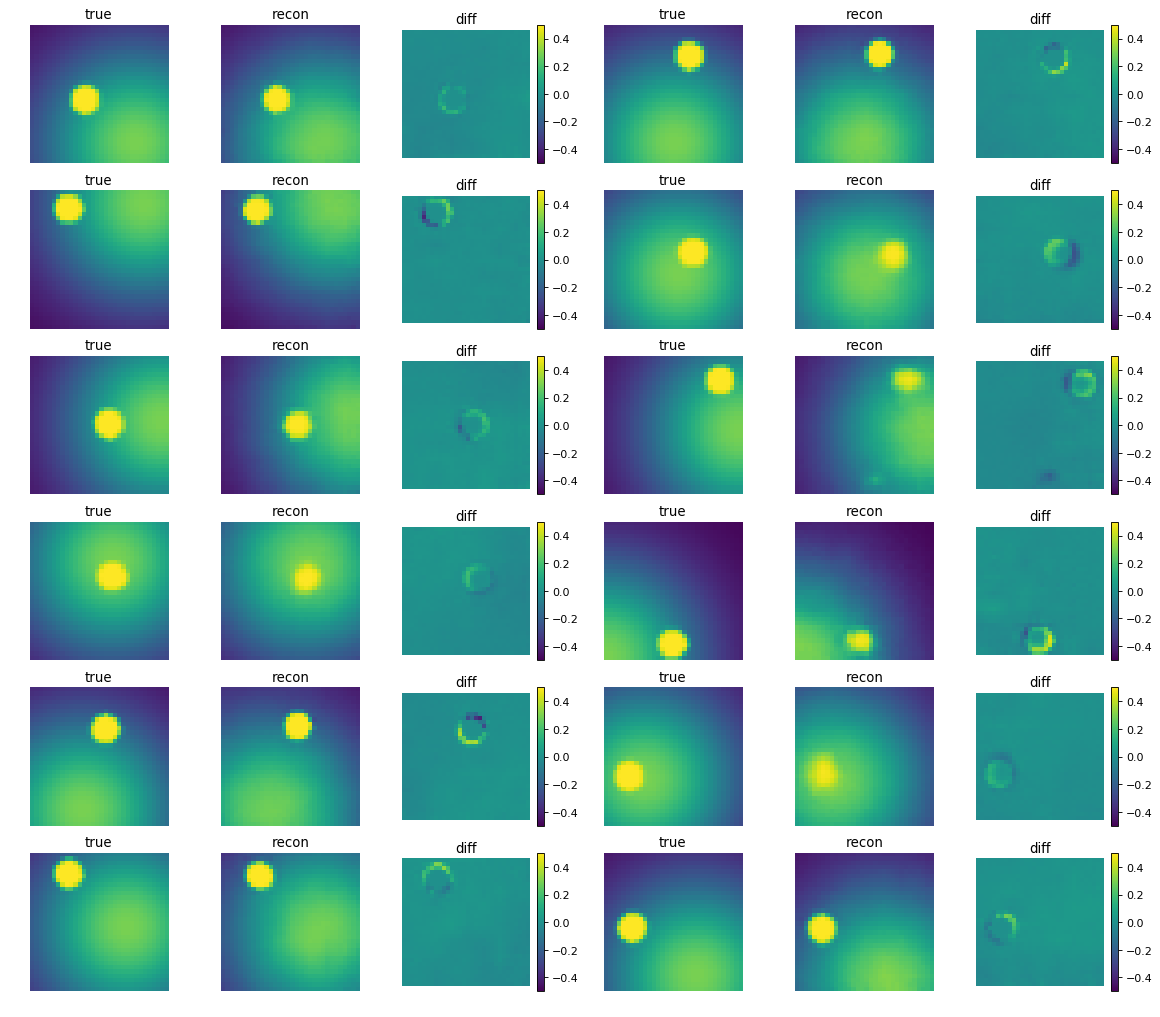

In [3]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
cnt = 0
for ii in range(12):
    x,label = ds[np.random.randint(1000)]
    x = x[np.newaxis, :, :]
    
    recon, mu, logvar = vae(torch.tensor(x).float())
    recon = recon.detach()
    
    diff = x - recon
    
    cnt += 1
    ax = plt.subplot(6,6,cnt)
    ax.imshow(x.squeeze(), vmin=0, vmax=1)
    plt.title('true')
    plt.axis('off')
    
    cnt += 1
    ax = plt.subplot(6,6,cnt)    
    ax.imshow(recon.squeeze(), vmin=0, vmax=1)
    plt.title('recon')
    plt.axis('off')
    
    cnt += 1
    ax = plt.subplot(6,6,cnt)    
    #m = torch.max(torch.abs(diff))
    m = .5
    img = ax.imshow(diff.numpy().squeeze(), vmin=-m, vmax=m)
    fig.colorbar(img)
    plt.title('diff')
    plt.axis('off')
    

### Testing the masking function (getCircleSegmentationMasks) of the dSpriteBackgroundDataset class

Text(0.5, 1.0, 'edge of object masked')

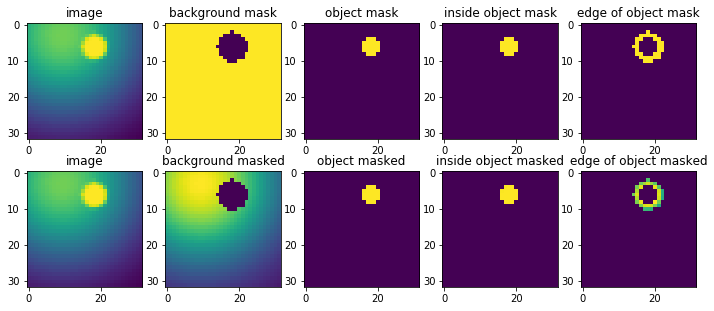

In [3]:


objx = .6
objy = .1
x = ds.arbitraryCircle(objx, objy, backx = .3, backy = .1)
backgroundMask, objectMask, insideObjectMask, objectEdgeMask = ds.getCircleSegmentationMasks(objx,objy)
    
_,ax = plt.subplots(2,5, figsize = (12, 5))
ax[0,0].imshow(x.squeeze())
ax[0,1].imshow(backgroundMask.squeeze())
ax[0,2].imshow(objectMask.squeeze())
ax[0,3].imshow(insideObjectMask.squeeze())
ax[0,4].imshow(objectEdgeMask.squeeze())


ax[1,0].imshow(x.squeeze())
xt = torch.zeros_like(x)
xt[backgroundMask] = x[backgroundMask]
ax[1,1].imshow(xt.squeeze())
xt = torch.zeros_like(x)
xt[objectMask] = x[objectMask]
ax[1,2].imshow(xt.squeeze())
xt = torch.zeros_like(x)
xt[insideObjectMask] = x[insideObjectMask]
ax[1,3].imshow(xt.squeeze())
xt = torch.zeros_like(x)
xt[objectEdgeMask] = x[objectEdgeMask]
ax[1,4].imshow(xt.squeeze())

ax[0,0].set_title('image')
ax[0,1].set_title('background mask')
ax[0,2].set_title('object mask')
ax[0,3].set_title('inside object mask')
ax[0,4].set_title('edge of object mask')
ax[1,0].set_title('image')
ax[1,1].set_title('background masked')
ax[1,2].set_title('object masked')
ax[1,3].set_title('inside object masked')
ax[1,4].set_title('edge of object masked')

### Plot reconstruction error for object, edge of object, background for different configurations of object and background

#### compute errors

In [6]:
x_ = np.linspace(0, 1., 5)
y_ = np.linspace(0, 1., 5)
X, Y = np.meshgrid(x_,y_)
n_xg = len(x_)
n_yg = len(y_)

# reconstruction error by x,y of gaussian and x,y of circle
insideCircleError = np.zeros((n_xg,n_yg,n_xg,n_yg))
edgeCircleError = np.zeros((n_xg,n_yg,n_xg,n_yg))
backgroundError = np.zeros((n_xg,n_yg,n_xg,n_yg))

# will contain a list of [distance_between_circle_and_gaussian, recon_error] paris
insideCircleErrorByDist = np.zeros((np.prod([n_xg,n_yg,n_xg,n_yg]),2))
edgeCircleErrorByDist = np.zeros((np.prod([n_xg,n_yg,n_xg,n_yg]),2))
backgroundErrorByDist = np.zeros((np.prod([n_xg,n_yg,n_xg,n_yg]),2))

cnt = 0
for ixgauss, x_gauss in enumerate(x_):
    for iygauss, y_gauss in enumerate(y_):
        
        for ixcirc, x_circ in enumerate(x_):
            for iycirc, y_circ in enumerate(y_):
                
                x = ds.arbitraryCircle(objx = x_circ, objy = y_circ, backx = x_gauss, backy = y_gauss)
                recon,_,_ = vae(x)
                               
                backgroundMask, objectMask, insideObjectMask, objectEdgeMask = ds.getCircleSegmentationMasks(objx,objy)
                
                err = torch.pow(x - recon,2)
                
                insideCircleError[ixgauss,iygauss,ixcirc,iycirc] = torch.mean(err[insideObjectMask])
                edgeCircleError[ixgauss,iygauss,ixcirc,iycirc] = torch.mean(err[objectEdgeMask])
                backgroundError[ixgauss,iygauss,ixcirc,iycirc] = torch.mean(err[backgroundMask])
                
                actdist = np.sqrt((x_gauss-x_circ)**2 + (y_gauss-y_circ)**2)
                insideCircleErrorByDist[cnt,0] = actdist
                insideCircleErrorByDist[cnt,1] = insideCircleError[ixgauss,iygauss,ixcirc,iycirc]
                backgroundErrorByDist[cnt,0] = actdist
                backgroundErrorByDist[cnt,1] = backgroundError[ixgauss,iygauss,ixcirc,iycirc]
                edgeCircleErrorByDist[cnt,0] = actdist
                edgeCircleErrorByDist[cnt,1] = edgeCircleError[ixgauss,iygauss,ixcirc,iycirc]
                
                cnt += 1


#### plot errors 

[Text(0.5, 0, 'distance bw circle and gauss')]

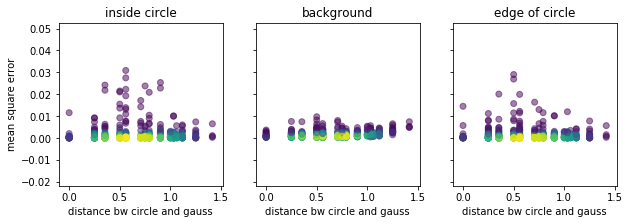

In [7]:
from matplotlib.colors import Normalize
from matplotlib import cm
from scipy.stats import gaussian_kde as kde

def makeColours( vals ):
    colours = np.zeros( (len(vals),3) )
    norm = Normalize( vmin=vals.min(), vmax=vals.max() )

    #Can put any colormap you like here.
    colours = [cm.ScalarMappable( norm=norm, cmap='viridis').to_rgba( val ) for val in vals]

    return colours

densObj0 = kde( insideCircleErrorByDist.T )
cols0 = makeColours(densObj0.evaluate(insideCircleErrorByDist.T))
densObj1 = kde( backgroundErrorByDist.T )
cols1 = makeColours(densObj1.evaluate(backgroundErrorByDist.T))
densObj2 = kde( edgeCircleErrorByDist.T )
cols2 = makeColours(densObj2.evaluate(edgeCircleErrorByDist.T))

_, axes = plt.subplots(1,3, sharey = True, sharex = True, figsize = (10,3))

axes[0].scatter(insideCircleErrorByDist[:,0], insideCircleErrorByDist[:,1], color=cols0, alpha = .5)
axes[0].set_title('inside circle')
axes[0].set(ylabel='mean square error')
axes[0].set(xlabel='distance bw circle and gauss')

axes[1].scatter(backgroundErrorByDist[:,0], backgroundErrorByDist[:,1], color=cols1, alpha = .5)
axes[1].set_title('background')
axes[1].set(xlabel='distance bw circle and gauss')

axes[2].scatter(edgeCircleErrorByDist[:,0], edgeCircleErrorByDist[:,1], color=cols2, alpha = .5)
axes[2].set_title('edge of circle')
axes[2].set(xlabel='distance bw circle and gauss')
